In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
!pip install jitcdde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.1/164.1 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 26.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for jitcdde: filename=jitcdde-1.8.1-py3-none-any.whl size=55003 sha256=724555986f3ed8ba4bd78b8d294ffa5f02efb61d33d7d9f466a76fb54ba35216
  Stored in directory: /root/.cache/pip/wheels/42/e3/4e/94b61188e5e3e62ba27e9586da5ecc7ea0f24e26916a250cc7
  Created wheel for chspy: filename=CHSPy-1.2.2-py3-none-any.whl size=11999 sha256=426d29ce9bc4f2f9b96d377dec034c20ae10e21d016a0e99c3704dd2fb6ba67a
  Stored in directory: /root/.cache/pip/wheels/11/17/24/0cca70842afd051f54325b813e637d8e8836d88c286ba63fae
  Created wheel for jitcxde_common: filename=jitcxde_common-1.5.4-py3-none-any.whl size=16755 sha256=286933ddf8bc54038b53971f184a1819006bb39d7c7235d6443043abc39351aa
  Stored in directory: /root/.cach

In [4]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from jitcdde import jitcdde, y, t
from numpy import pi, arange, random, max
import symengine
from scipy.signal import welch
from tqdm import tqdm
import os

In [5]:
weight_filename = "gdrive/MyDrive/PBM-report2/WeightedA33.dat"
# mapping_filename = "gdrive/MyDrive/PBM-report2/Categorized_Brain_Nodes.csv"
mapping_filename = "gdrive/MyDrive/PBM-report2/Y_Categorized_Brain_Nodes.csv"
fiber_length_filename = "gdrive/MyDrive/PBM-report2/LengthFibers33.dat"

w_kj = np.loadtxt(weight_filename)
num_nodes = w_kj.shape[0]

In [6]:
def load_node_categories(filepath):
    node_data = pd.read_csv(filepath)
    node_data['Node'] = node_data['Node'] - 1
    node_groups = node_data.groupby('new_Super_Region')['Node'].apply(list).to_dict()
    return node_groups

In [7]:
# Define the differential equation model
def dcdt(c_k, q_k, w_kj, alpha):
    # Define the graph Laplacian matrix L
    D = np.diag(w_kj.sum(axis=1))
    L = rho * (D - w_kj)
    return -L.dot(c_k) + alpha * c_k * (1 - c_k)

def dqdt(c_k, q_k, beta):
    return beta * c_k * (1 - q_k)

def dwdt(w_kj, q_k, gamma):
    q_sum = q_k[:, None] + q_k  # Calculate the sum of damage
    return -gamma * w_kj * q_sum

# Integrate the model equations
def model(y, t, beta, gamma):
    num_variables = 2 * num_nodes + num_nodes**2
    c_k = y[:num_nodes]
    q_k = y[num_nodes:2*num_nodes]
    w_kj = y[2*num_nodes:num_variables].reshape((num_nodes, num_nodes))

    # Calculate dc/dt, dq/dt, dw/dt
    dc_dt = dcdt(c_k, q_k, w_kj, alpha)
    dq_dt = dqdt(c_k, q_k, beta)
    dw_dt = dwdt(w_kj, q_k, gamma).flatten()

    # Merge them back into a flat array
    dydt = np.concatenate((dc_dt, dq_dt, dw_dt))
    return dydt

[ 0.          1.03448276  2.06896552  3.10344828  4.13793103  5.17241379
  6.20689655  7.24137931  8.27586207  9.31034483 10.34482759 11.37931034
 12.4137931  13.44827586 14.48275862 15.51724138 16.55172414 17.5862069
 18.62068966 19.65517241 20.68965517 21.72413793 22.75862069 23.79310345
 24.82758621 25.86206897 26.89655172 27.93103448 28.96551724 30.        ]


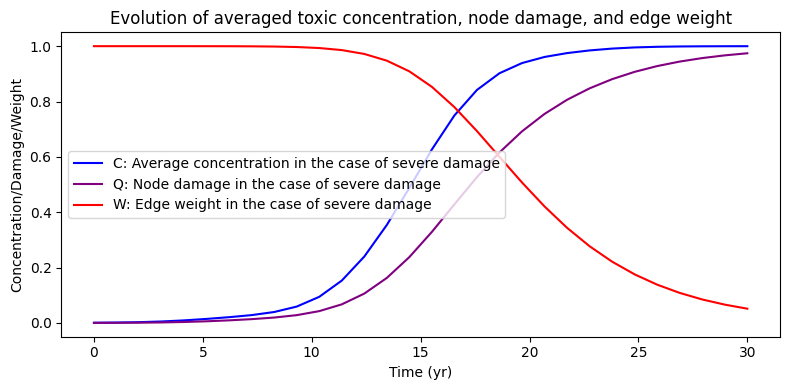

In [8]:
# Initialize c_k (toxic protein concentration), q_k (node damage), and w_kj (edge weight)
c_k = np.zeros(num_nodes)
q_k = np.zeros(num_nodes)

seed_protein_concentration = 0.025

# Define model parameters
alpha = 0.75  # 3/4 per year
beta_severe = 1 / 4
gamma_severe = 1 / 8
rho = 1 / 100  # mm/yr, Laplacian rate constant

# Assume that the node indexes corresponding to the medial frontal area are 26 and 68
entorhinal_nodes = [26, 68]
for entorhinal_node in entorhinal_nodes:
    c_k[entorhinal_node-1] = seed_protein_concentration

np.random.seed(42)

# Set the time points
transport_times = np.linspace(0, 30, 30) # From 0 to 30 years, a total of 1000 time points
print(transport_times)
# Set initial conditions
y0 = np.concatenate((c_k, q_k, w_kj.flatten()))

# Severe damage (β=1/4, γ=1/8)
sol_severe = odeint(model, y0, transport_times, args=(beta_severe, gamma_severe))
c_k_severe = sol_severe[:, :num_nodes]
q_k_severe = sol_severe[:, num_nodes:2*num_nodes]
w_kj_severe = sol_severe[:, 2*num_nodes:].reshape((len(transport_times), num_nodes, num_nodes))
C_T_severe = c_k_severe.mean(axis=1)
Q_severe = q_k_severe.mean(axis=1)
W_severe = np.array([np.linalg.norm(w) / np.linalg.norm(w_kj) for w in w_kj_severe])

# Plot the results
plt.figure(figsize=(8, 4))
plt.plot(transport_times, C_T_severe, 'b-', label='C: Average concentration in the case of severe damage')
plt.plot(transport_times, Q_severe, color="purple", label='Q: Node damage in the case of severe damage')
plt.plot(transport_times, W_severe, 'r-', label='W: Edge weight in the case of severe damage')
plt.title('Evolution of averaged toxic concentration, node damage, and edge weight')
plt.xlabel('Time (yr)')
plt.ylabel('Concentration/Damage/Weight')
plt.legend()
plt.tight_layout()
plt.show()

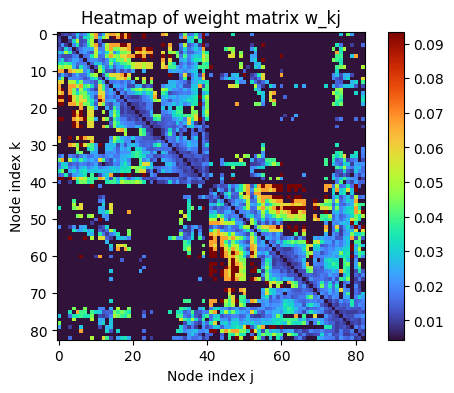

In [9]:
tau_kj = np.loadtxt(fiber_length_filename)
tau_kj = tau_kj/1500

# We flatten the array for the qcut function and then reshape it back to the original shape.
discretized_data, bins = pd.qcut(tau_kj.ravel(), 40, retbins=True, labels=False, duplicates='drop')

# Calculate the mean of the bins
bin_means = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins) - 1)]

# Map discretized data to the mean of the interval
discretized_tau_kj = np.array([bin_means[i] for i in discretized_data])
discretized_tau_kj = discretized_tau_kj.reshape(tau_kj.shape)

# Plotting the heatmap
plt.figure(figsize=(6, 4))
heatmap = plt.imshow(discretized_tau_kj, cmap='turbo')
plt.colorbar(heatmap)
plt.title('Heatmap of weight matrix w_kj')
plt.xlabel('Node index j')
plt.ylabel('Node index k')
plt.show()

In [10]:
def calculate_decayed_speed(w_kj_severe):
    num_time_points = w_kj_severe.shape[0]
    decay_rates = np.zeros(num_time_points)  # decay rate from each time point to the next
    decay_rates[0] = 0
    for t in range(1, num_time_points):
        norm_current = np.linalg.norm(w_kj_severe[t])
        norm_previous = np.linalg.norm(w_kj_severe[t - 1])
        decay_rate = (norm_current - norm_previous) / norm_previous
        decay_rates[t] = decay_rate

    return 1500 + decay_rates*1500

In [11]:
def load_and_discretise_tau(fiber_length_filename, speed):
  tau_kj = np.loadtxt(fiber_length_filename)
  tau_kj = tau_kj/speed

  # We flatten the array for the qcut function and then reshape it back to the original shape.
  discretized_data, bins = pd.qcut(tau_kj.ravel(), 40, retbins=True, labels=False, duplicates='drop')

  # Calculate the mean of the bins
  bin_means = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins) - 1)]

  # Map discretized data to the mean of the interval
  discretized_tau_kj = np.array([bin_means[i] for i in discretized_data])
  discretized_tau_kj = discretized_tau_kj.reshape(tau_kj.shape)

  return discretized_tau_kj

In [12]:
def sigmoid(x):
    return 1 / (1 + symengine.exp(-x))

def rsd_model(w_kj, tau_kj):
  n = num_nodes
  mean_omega = 40
  variance_omega = 0.1
  ω = np.random.normal(mean_omega, np.sqrt(variance_omega), n)
  c = 42
  λ = -0.01
  A = w_kj
  τ = discretized_tau_kj
  k = 10

  def resting_state_model():
    for i in range(num_nodes):
      # calculate the coupling sum for excitatory population
      coupling_sum = sum( A[i,j]*y(2*j, t-τ[i,j]) for j in range(num_nodes) )
      # apply the sigmoid functuon to the coupling term
      coupling_term = sigmoid(coupling_sum)

      # Excitatory population equation
      yield λ * y(2*i) - ω[i]*y(2*i+1) - y(2*i) * (y(2*i)**2 + y(2*i+1)**2) + k*coupling_term

      # Inhibitory population equation
      yield λ * y(2*i+1) + ω[i]*y(2*i) - y(2*i+1) * (y(2*i)**2 + y(2*i+1)**2)

  I = jitcdde(resting_state_model,n=2*n,verbose=False,delays=τ.flatten())
  I.set_integration_parameters(rtol=0,atol=1e-5)

  I.constant_past( np.random.rand(n*2), time=0.0 )
  I.integrate_blindly( max(τ) , 0.01 )

  # Time span for integration (10 seconds)
  t_end = 12
  dt = 0.01  # Adjust dt to the desired time resolution
  times = np.arange(2, t_end, dt)
  data = np.zeros((len(times), n*2))  # Pre-allocate space for efficiency

  # for time in I.t + arange(0,10,0.01):
  #   print(I.integrate(time))

  # Integrate and store the data
  for i, time in enumerate(times):
      data[i] = I.integrate(time)

  exc = data[:,:83]
  inh = data[:,83:]
  return exc, inh, dt, times, ω

In [13]:
def compute_biomarkers(excitatory, inhibitory, dt, omega, node_groups, nperseg=None):
    fs = 1 / dt
    z = excitatory + 1j * inhibitory
    results = {}

    # Compute global metric "at" only
    global_AT = np.mean(np.trapz(np.abs(z), dx=1 / fs, axis=0))
    results['global'] = global_AT

    # Compute "at" for each region
    for region, nodes in node_groups.items():
        region_AT = np.mean(np.trapz(np.abs(z[:, nodes]), dx=1 / fs, axis=0))
        results[region] = region_AT

    return results

In [14]:
def run_simulation(w_kj, save_path, node_groups, decay_in_speed):
    region_metrics = {region: {'at': []} for region in node_groups}
    region_metrics['global'] = {'at': []}

    if decay_in_speed == True:
      decay_speed = calculate_decayed_speed(w_kj_severe)
    else:
      decay_speed = np.ones(len(transport_times))*1500

    for i, w in enumerate(tqdm(w_kj, desc="Simulation Progress")):
        tau_kj = load_and_discretise_tau(fiber_length_filename, decay_speed[i])
        exc, inh, dt, times, omega = rsd_model(w, tau_kj)
        all_region_metrics = compute_biomarkers(exc, inh, dt, omega, node_groups)

        for region in all_region_metrics:
            region_metrics[region]['at'].append(all_region_metrics[region])

    for region, metrics in region_metrics.items():
        if decay_in_speed == True:
          file_path = os.path.join(save_path, f'dynamic_biomarkers_{region}_with_decay.npy')
        else:
          file_path = os.path.join(save_path, f'dynamic_biomarkers_{region}_without_decay.npy')
        new_data = np.array(metrics['at'])
        if os.path.exists(file_path):
            existing_data = np.load(file_path, allow_pickle=True)
            combined_data = np.concatenate((existing_data, new_data), axis=0)  # Change to axis=0 for simplicity
        else:
            combined_data = new_data
        np.save(file_path, combined_data)

    return region_metrics

In [23]:
def calculate_statistics(number_of_realizations, all_region_metrics, decay_conditions):
    stats = {condition: {'global': {}, 'limbic': {}} for condition in decay_conditions}

    for condition in decay_conditions:
        for region in ['global', 'limbic']:
            metric_data = np.array(all_region_metrics[condition][region]['at']).reshape((number_of_realizations, -1))
            normalized_metric_data = metric_data / metric_data[:,0].reshape(-1,1)
            mean = np.mean(normalized_metric_data, axis=0)
            std = np.std(normalized_metric_data, axis=0)
            stats[condition][region]['at'] = (mean, std)

    return stats

def plot_statistics(stats, decay_conditions):
    shades_of_black = ['black', 'dimgray']  # Different shades for global
    shades_of_blue = ['navy', 'mediumblue']  # Different shades for limbic

    fig, ax = plt.subplots(figsize=(9, 4.5))

    for condition, color_global, color_limbic in zip(decay_conditions, shades_of_black, shades_of_blue):
        for region, color in [('global', color_global), ('limbic', color_limbic)]:
            mean, std = stats[condition][region]['at']
            ax.errorbar(transport_times, mean, yerr=std, fmt='-', label=f'Decay: {condition}, Region: {region}',
                        color=color, ecolor=color, capsize=2, elinewidth=0.5)

    # ax.set_title('AT Across Realizations with/without decay in speed')
    ax.set_xlabel('Time T (yr)', fontsize=15)
    ax.set_ylabel('AT Value', fontsize=15)
    ax.plot(transport_times, C_T_severe, alpha=0.2, linewidth=3.5, color='gray')
    ax.legend(fontsize=15)
    plt.tight_layout()
    plt.show()

In [27]:
save_path = 'gdrive/MyDrive/PBM-report2/extended_fig'
node_groups = load_node_categories(mapping_filename)
number_of_realizations = 2  # Number of times the simulation will run for each condition

# Define the decay in speed conditions
decay_conditions = [True, False]  # True for with decay, False for without decay
all_region_metrics = {condition: {region: {'at': []} for region in ['global', 'limbic']} for condition in decay_conditions}

for condition in decay_conditions:
    for realization_index in range(number_of_realizations):
        region_metrics = run_simulation(w_kj_severe, save_path, node_groups, condition)

        for region in ['global', 'limbic']:
            all_region_metrics[condition][region]['at'].append(region_metrics[region]['at'])

Simulation Progress: 100%|██████████| 30/30 [22:29<00:00, 44.98s/it]


In [16]:
def load_and_aggregate_metrics(save_path, node_groups, decay_conditions):
    all_region_metrics = {condition: {region: {'at': []} for region in ['global', 'limbic']} for condition in decay_conditions}

    for condition in decay_conditions:
        for region in ['global', 'limbic']:
            if condition == True:
              file_path = os.path.join(save_path, f'dynamic_biomarkers_{region}_with_decay.npy')
            else:
              file_path = os.path.join(save_path, f'dynamic_biomarkers_{region}_without_decay.npy')
            if os.path.exists(file_path):
                data = np.load(file_path, allow_pickle=True)
                # Assume each file directly contains the 'at' metric data as an array
                all_region_metrics[condition][region]['at'] = data.tolist()

    return all_region_metrics

In [18]:
# Example usage
decay_conditions = [True, False]
node_groups = load_node_categories(mapping_filename)  # Load node categories as before
save_path = 'gdrive/MyDrive/PBM-report2/extended_fig'

# Load and aggregate metrics for each xi

all_region_metrics = load_and_aggregate_metrics(save_path, node_groups, decay_conditions)

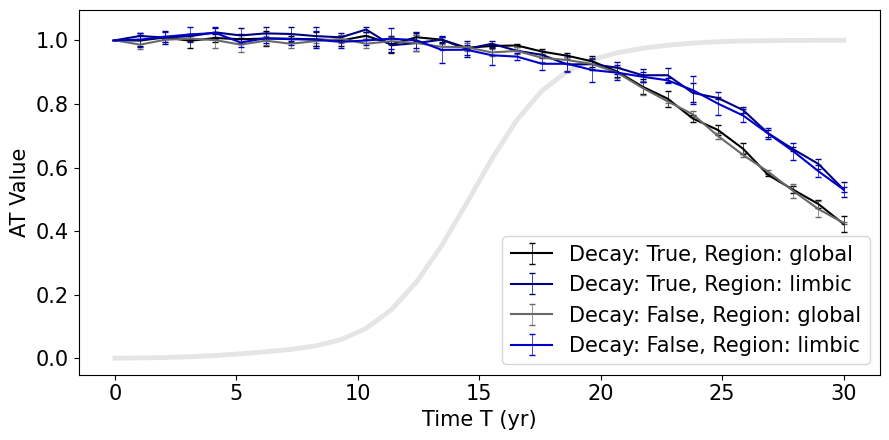

In [24]:
import matplotlib
matplotlib.rc('xtick', labelsize=15)
matplotlib.rc('ytick', labelsize=15)
stats = calculate_statistics(3, all_region_metrics, decay_conditions)
plot_statistics(stats, decay_conditions)